# Red Light, Green Light: Dynamic Traffic Lights with RL
## By Erin Gregoire & Daniel Viola
### Spring 2025

In [1]:
import gymnasium as gym
import sumo_rl
import os
os.environ["SUMO_HOME"] = r"C:\Program Files (x86)\Eclipse\Sumo"
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
import traci

In [2]:
class SARSAagent:
    def __init__(self, env, learned_table=False, pickle_file=None):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

        if learned_table:
            with open(pickle_file, 'rb') as f:
                self.q_table = pickle.load(f)
        else:
            self.q_table = {}

    def step(self, obs, epsilon):
        active_green = tuple(obs[0:4])
        lane_queue = obs[13:22]
        queue_buckets = []
        for i in lane_queue:
            if i < .1:
                queue_buckets.append(1)
            elif .1 <= i < .2:
                queue_buckets.append(2)
            elif .2 <= i < .3:
                queue_buckets.append(3)
            elif .3 <= i < .4:
                queue_buckets.append(4)
            elif .4 <= i < .5:
                queue_buckets.append(5)
            elif .5 <= i < .6:
                queue_buckets.append(6)
            elif .6 <= i < .7:
                queue_buckets.append(7)
            elif .7 <= i < .8:
                queue_buckets.append(8)
            elif .8 <= i < .9:
                queue_buckets.append(9)
            else:
                queue_buckets.append(10)
        queue_buckets = tuple(queue_buckets)       
        obs_key = (active_green, queue_buckets)
        if obs_key not in self.q_table.keys():
            self.q_table[obs_key] = np.zeros(self.action_space.n)
        
        if np.random.random() < epsilon: 
            return np.random.choice(self.action_space.n)
        else:
            return np.argmax(self.q_table[obs_key]) 
        
    def update(self, obs, next_obs, action, reward, alpha, gamma, terminated):
        active_green = tuple(obs[0:4])
        lane_queue = obs[13:22]
        queue_buckets = []
        for i in lane_queue:
            if i < .1:
                queue_buckets.append(1)
            elif .1 <= i < .2:
                queue_buckets.append(2)
            elif .2 <= i < .3:
                queue_buckets.append(3)
            elif .3 <= i < .4:
                queue_buckets.append(4)
            elif .4 <= i < .5:
                queue_buckets.append(5)
            elif .5 <= i < .6:
                queue_buckets.append(6)
            elif .6 <= i < .7:
                queue_buckets.append(7)
            elif .7 <= i < .8:
                queue_buckets.append(8)
            elif .8 <= i < .9:
                queue_buckets.append(9)
            else:
                queue_buckets.append(10)
        queue_buckets = tuple(queue_buckets)
        obs_key = (active_green, queue_buckets)
        
        next_active_green = tuple(next_obs[0:4])
        next_lane_queue = next_obs[13:22]
        next_queue_buckets = []
        for i in next_lane_queue:
            if i < .1:
                next_queue_buckets.append(1)
            elif .1 <= i < .2:
                next_queue_buckets.append(2)
            elif .2 <= i < .3:
                next_queue_buckets.append(3)
            elif .3 <= i < .4:
                next_queue_buckets.append(4)
            elif .4 <= i < .5:
                next_queue_buckets.append(5)
            elif .5 <= i < .6:
                next_queue_buckets.append(6)
            elif .6 <= i < .7:
                next_queue_buckets.append(7)
            elif .7 <= i < .8:
                next_queue_buckets.append(8)
            elif .8 <= i < .9:
                next_queue_buckets.append(9)
            else:
                next_queue_buckets.append(10)
        next_queue_buckets = tuple(next_queue_buckets)
        next_obs_key = (next_active_green, next_queue_buckets)
        if next_obs_key not in self.q_table.keys():
            self.q_table[next_obs_key] = np.zeros(self.action_space.n)
        
        last_q = self.q_table[obs_key][action]
        if terminated:
            next_q = 0
        else:
            next_q = self.q_table[next_obs_key][action]
        q = last_q + alpha * (reward + (gamma * next_q) - last_q)
        self.q_table[obs_key][action] = q

In [3]:
def create_pickle_file(weights, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(weights, f)

In [4]:
 # utilize epsilon decay for first half of episode and only greedy actions for second half
def choose_epsilon(timestep):
    if timestep >= (8000):
        epsilon = 0
    else:
        epsilon_vals = [(((.01/1)**(1/(8000))) ** i) * 1 for i in range(8000)]
        epsilon = epsilon_vals[timestep]
    return epsilon

In [11]:
# new reward structure
# only update q-value during training
# 10 uniform queue buckets instead of 4
# new graph to plot average vehicle wait time
# started at __________

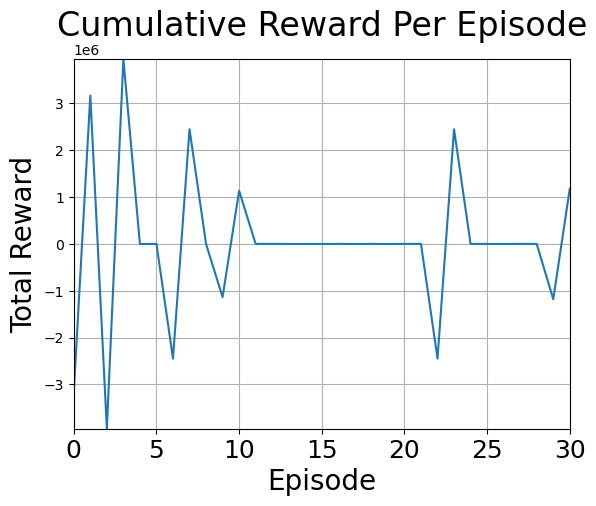

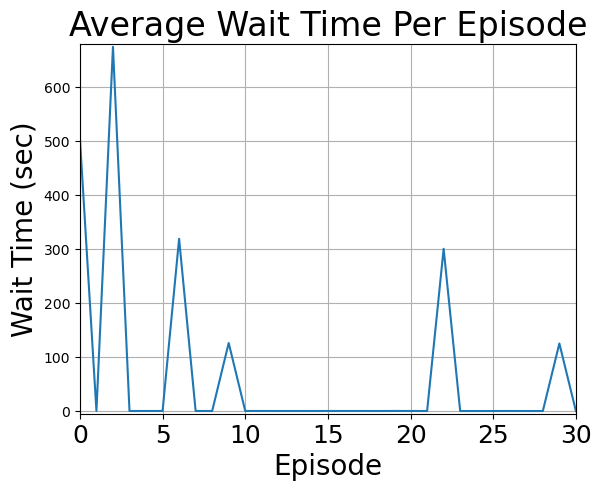

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
def looping_time(): # 2 way single intersection
        steps = 80000
        env = gym.make("sumo-rl-v0",
            net_file=r"C:\Users\egreg\Documents\Reinforcement Learning\Final Project\intersection_data\single-intersection.net.xml",
            route_file=r"C:\Users\egreg\Documents\Reinforcement Learning\Final Project\intersection_data\single-intersection-gen.rou.xml",
            out_csv_name="sarsa_results_single_intersection",
            use_gui=False,
            single_agent=True,
            num_seconds=steps)
        agent=SARSAagent(env)
        episodes = 31
        gamma = 0.99
        alpha = 0.01
        cumulative_rewards = []
        previous_wait = 0
        current_wait = 0
        average_wait_per_car = []

        for i in range(episodes):
            ep_reward = 0
            timestep = 0
            departed_total = 0
            obs, info = env.reset()
            
            terminated, truncated = False, False
            while not (terminated or truncated):
                action = agent.step(obs, choose_epsilon(timestep))
                next_obs, reward, terminated, truncated, info = env.step(action)
                timestep += 1
                current_wait = info.get("system_total_waiting_time", 0)
                reward = previous_wait - current_wait
                previous_wait = current_wait
                departed_total += traci.simulation.getDepartedNumber()
                if timestep < 8000: # only update q-value in training
                    agent.update(obs, next_obs, action, reward, alpha, gamma, terminated)
                ep_reward += reward
                obs = next_obs
            cumulative_rewards.append(ep_reward)
            average_wait_per_car.append(info["system_total_waiting_time"] / max(departed_total, 1))

        # total reward per episode
        plt.figure()
        plt.plot(cumulative_rewards)
        plt.xlabel('Episode', fontsize=20)
        plt.ylabel('Total Reward', fontsize=20)
        plt.title('Cumulative Reward Per Episode', fontsize=24)
        plt.xticks(fontsize=18)
        plt.ylim(ymin=(min(cumulative_rewards)-5), ymax=(max(cumulative_rewards)+5))
        plt.xlim(xmin=0, xmax=episodes-1)
        plt.grid()
        plt.show()

        # average wait per vehicle
        plt.figure()
        plt.plot(average_wait_per_car)
        plt.xlabel('Episode', fontsize=20)
        plt.ylabel('Wait Time (sec)', fontsize=20)
        plt.title('Average Wait Time Per Episode', fontsize=24)
        plt.xticks(fontsize=18)
        plt.ylim(ymin=(min(average_wait_per_car)-5), ymax=(max(average_wait_per_car)+5))
        plt.xlim(xmin=0, xmax=episodes-1)
        plt.grid()
        plt.show()

        # save results
        create_pickle_file(agent.q_table, 'SARSAagent_q_table.pkl')
        env.close()

        # print q-table
        data = []
        for state, actions in agent.q_table.items():
            row = [state] + list(actions)
            data.append(row)
        columns = ["State"] + [f"Action {i}" for i in range(len(actions))]
        df = pd.DataFrame(data, columns=columns)
        print(df)

looping_time()

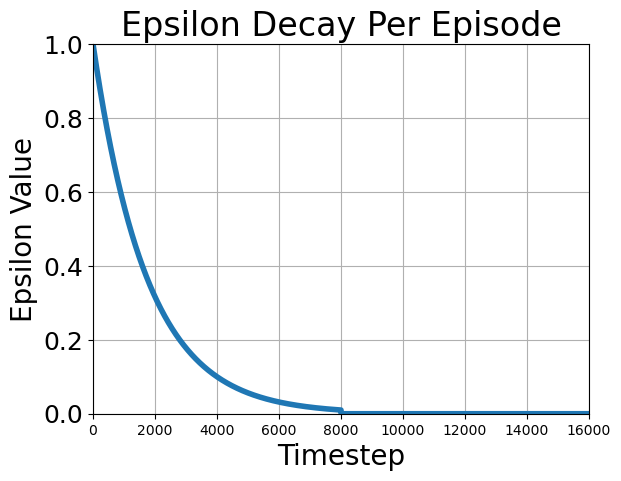

In [11]:
# epsilon decay graph:
epsilon_vals = [(((.01/1)**(1/(8000))) ** i) * 1 for i in range(8000)]
for i in range(8000):
    epsilon_vals.append(i*0)
    
plt.figure()
plt.plot(epsilon_vals, linewidth=4)
plt.xlabel('Timestep', fontsize=20)
plt.ylabel('Epsilon Value', fontsize=20)
plt.title('Epsilon Decay Per Episode', fontsize=24)
plt.yticks(fontsize=18)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=16000)
plt.grid()
plt.show()

## Evaluation Run

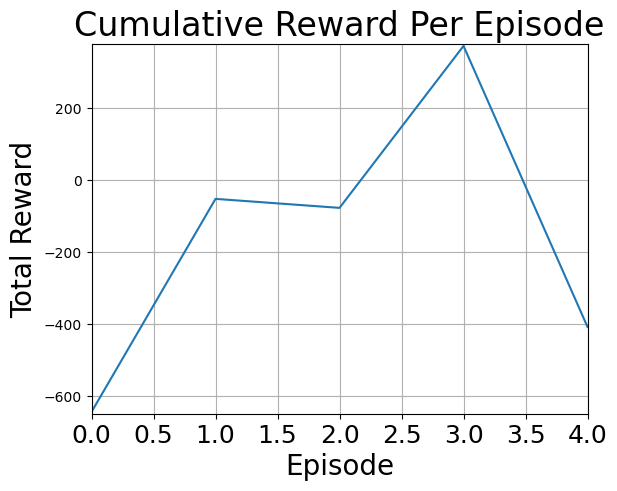

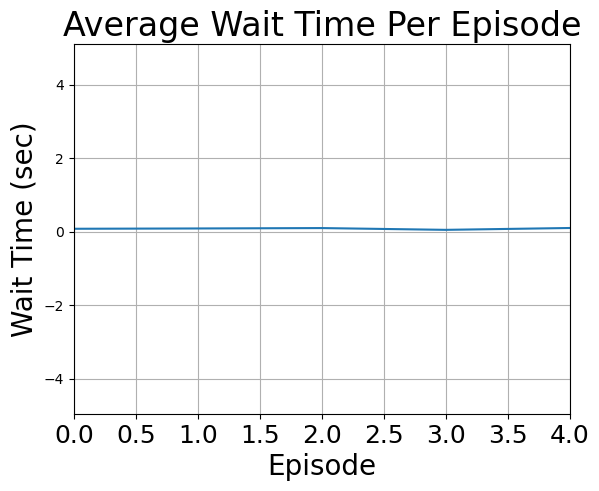

In [11]:
def eval_looping_time(): # 2 way single intersection
        steps = 60000
        env = gym.make("sumo-rl-v0",
            net_file=r"C:\Users\egreg\Documents\Reinforcement Learning\Final Project\intersection_data\single-intersection.net.xml",
            route_file=r"C:\Users\egreg\Documents\Reinforcement Learning\Final Project\intersection_data\single-intersection-gen.rou.xml",
            out_csv_name="sarsa_results_single_intersection_evaluation",
            use_gui=True,
            single_agent=True,
            num_seconds=steps)
        agent=SARSAagent(env, learned_table=True, pickle_file='ergregoi_dviola_single_intersection_sarsa_q_table.pkl')
        episodes = 5
        gamma = 0.99
        alpha = 0.001
        epsilon = 0
        cumulative_rewards = []
        previous_wait = 0
        current_wait = 0
        average_wait_per_car = []

        for i in range(episodes):
            ep_reward = 0
            departed_total = 0
            obs, info = env.reset()
            
            terminated, truncated = False, False
            while not (terminated or truncated):
                action = agent.step(obs, epsilon)
                next_obs, reward, terminated, truncated, info = env.step(action)
                current_wait = info.get("system_total_waiting_time", 0)
                reward = previous_wait - current_wait
                previous_wait = current_wait
                departed_total += traci.simulation.getDepartedNumber()
                ep_reward += reward
                obs = next_obs
            cumulative_rewards.append(ep_reward)
            average_wait_per_car.append(info["system_total_waiting_time"] / max(departed_total, 1))

        # total reward per episode
        plt.figure()
        plt.plot(cumulative_rewards)
        plt.xlabel('Episode', fontsize=20)
        plt.ylabel('Total Reward', fontsize=20)
        plt.title('Cumulative Reward Per Episode', fontsize=24)
        plt.xticks(fontsize=18)
        plt.ylim(ymin=(min(cumulative_rewards)-5), ymax=(max(cumulative_rewards)+5))
        plt.xlim(xmin=0, xmax=episodes-1)
        plt.grid()
        plt.show()

        # average wait per vehicle
        plt.figure()
        plt.plot(average_wait_per_car)
        plt.xlabel('Episode', fontsize=20)
        plt.ylabel('Wait Time (sec)', fontsize=20)
        plt.title('Average Wait Time Per Episode', fontsize=24)
        plt.xticks(fontsize=18)
        plt.ylim(ymin=(min(average_wait_per_car)-5), ymax=(max(average_wait_per_car)+5))
        plt.xlim(xmin=0, xmax=episodes-1)
        plt.grid()
        plt.show()

eval_looping_time()